In [ ]:
import numpy as np
import matplotlib.pyplot as plt

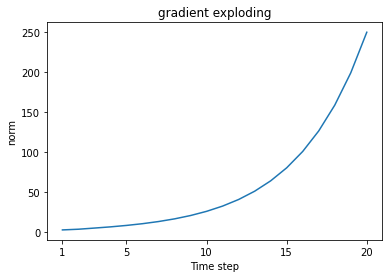

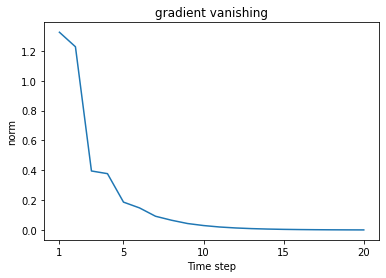

In [ ]:
# why LSTM?
# RNN problems : check backprop
# (tanh -> matmul) -> (tanh -> matmul)...

# just consider matmul

def gradient_plot(T, norm_list, title):
  plt.plot(range(1,T+1), norm_list)
  plt.title(title)
  plt.xticks([1, 5, 10, 15, 20])
  plt.xlabel('Time step')
  plt.ylabel('norm')
  plt.show()

N = 2     # mini-batch
H = 3     # hidden vector
T = 20    # length of time series

dh = np.ones((N, H))                # for gradient exploding
dh2 = np.ones((N, H))               # for gradient vanishing
np.random.seed(3)                   # for fix random seed
Wh = np.random.randn(H, H)          # for gradient exploding
Wh2 = np.random.randn(H, H) * 0.5    # for gradient vanishing

norm_list = []
norm_list2 = []
for t in range(T):
  dh = np.matmul(dh, Wh.T)
  dh2 = np.matmul(dh2, Wh2.T)
  norm = np.sqrt(np.sum(dh**2)) / N
  norm2 = np.sqrt(np.sum(dh2**2)) / N
  norm_list.append(norm)
  norm_list2.append(norm2)

gradient_plot(T, norm_list, 'gradient exploding')
gradient_plot(T, norm_list2, 'gradient vanishing')

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

class LSTM():
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_liek(Wx), np.zeros_like(Wh), np.zeros_liek(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    # Affine transformation (Wx[f, g, i, o], Wh[f, g, i, o], b[f, g, i, o])
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

    # slice for gates and get
    forget = A[:, :H]       # NxH
    get = A[:, H:2*H]
    input = A[:, 2*H:3*H]
    ouput = A[:, 3*H:4*H]

    forget = sigmoid(forget)   # forget gate
    get = np.tanh(get)        # new memory
    input = sigmoid(input)    # input gate
    ouput = sigmoid(ouput)    # output gate

    c_next = (c_prev * forget) + (get * input)
    h_next = np.tanh(c_next) * ouput

    self.cache = (x, h_prev, c_prev, input, forget, get, output, c_next)
    return h_next, c_next

  def backward(self, dh_next, dc_next):
    Wx, Wh, b = self.params
    x, h_prev, c_prev, input, forget, get, output, c_next = self.cache

    # chain rule
    do = dh_next * np.tanh(c_next)
    do_s = do * ouput*(1-output)
    dt = dh_next * ouput
    dt_c = dt * (1-(np.tanh(c_next)**2))

    di = dt_c * get
    dg = dt_c * input
    di_s = di * input*(1-input)
    dg_t = dg * (1-(g**2))

    dc_prev = dt_c * f
    df = dt_c * c_prev
    df_s = df * forget*(1-forget)

    dA = np.hstack(df_s, dg_t, di_s, do_s)

    db = np.sum(dA, axis = 0)
    dWh = np.matmul(h_prev.T, dA)
    dh_prev = np.matmul(dA, Wh.T)
    dWx = np.matmul(x.T, dA)
    dx = np.matmul(dA, Wx.T)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev, dc_prev

In [ ]:
# Time LSTM
class TimeLSTM():
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None      # for LSTM layer
    self.h, self.c = None, None
    self.dh = None
    self.stateful = stateful

  def set_state(self, h, c=None):
    self.h, self.c = h, c

  def reset_state(self):
    self.h, self.c = None, None

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape      # mini-batch, time length, Dimension
    H = Wh.shape[0]         # Wh (H, 4H) H: hidden size
    
    self.layers = []        # for stacking LSTM layer (horizontal)
    hs = np.empty((N, T, D), dtype='f')   # for save (h0 ... ht)
    
    # if not stateful, initialize h and c
    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')

    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h
      self.layers.append(layer)

    return hs
    
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0

    grads = [0, 0, 0]   #dWx, dWh, db
    for t in reversed(range(T)):  # BPTT
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:,t ,:] + dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    
    self.dh = dh
    return dxs
  